# Map-Making using Planck Acquisition

In this notebook, we describe how to make the map-making process using Planck acquisition to correct edge effects. We will merge QUBIC and Planck acquisition to benefit of both instrument, QUBIC for the Q and U sensitivity and Planck for the large coverage and sensitivity on I.

In [1]:
from __future__ import division
from pyoperators import pcg
from pysimulators import profile

import sys
sys.path.append('/Users/mregnier/Desktop/PhD Regnier/mypackages')

# QUBIC packages
import qubic
from qubicpack.utilities import Qubic_DataDir
from qubic.data import PATH
from qubic.io import read_map
from qubic import QubicSkySim as qss
import Acquisition as Acq

# Display packages
import healpy as hp
import matplotlib.pyplot as plt

# FG-Buster packages
import component_model as c
import mixing_matrix as mm

# General packages
import numpy as np
import pysm3
import warnings
from qubic import QubicSkySim as qss
import pysm3.units as u
from importlib import reload
from pysm3 import utils

# PyOperators packages
from pyoperators import (
    BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator,
    CompositionOperator, DiagonalOperator, I, IdentityOperator,
    MPIDistributionIdentityOperator, MPI, proxy_group, ReshapeOperator,
    rule_manager, pcg, Operator)

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
warnings.filterwarnings("ignore")
%matplotlib inline

# %config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/


# QUBIC dictionary

We first import the QUBIC dictionary to define general stuff like pixelization, seen region on the sky, etc... 

In [2]:
def initial_guess_pcg(map, n, Nrec, npix):

    initial_guess = np.zeros((Nrec, npix, 3))
    for i in range(Nrec):
        initial_guess[i] = map + n
    
    return initial_guess
def integration(nu_min, nu_max, Nintegr, sky_config, d):
    print(f'Integration from {nu_min:.2f} to {nu_max:.2f} GHz with {Nintegr} steps')
    obj = Acq.QubicIntegrated(d, Nsub=Nintegr, Nrec=Nintegr)
    if Nintegr == 1:
        allnus = np.array([np.mean([nu_min, nu_max])])
    else:
        allnus = np.linspace(nu_min, nu_max, Nintegr)
    m = obj.get_PySM_maps(sky_config, nus=allnus)
    #print(m.shape)
    
    return np.array([np.mean(m, axis=0)])

In [3]:
print('\n******* Dictionary *******\n')

dictfilename = 'dicts/pipeline_demo.dict'

d = qubic.qubicdict.qubicDict()
d.read_from_file(dictfilename)

Nrec = 2
fact = 2
Nsub = int(Nrec * fact)
Nbfreq, nus_edge, nus, deltas, Delta, Nbbands = qubic.compute_freq(220, Nfreq=Nsub)
band = 217
sky_config = {'dust':'d0'}

nside = 256
pointings = 3000
ite = 1
noisy = 1
convolution = False
convolution_to_max=False
correction = False

d['nf_recon'] = Nrec
d['nf_sub'] = Nrec
d['nside'] = 256
npix=12*d['nside']**2
d['RA_center'] = 0
d['DEC_center'] = -57
center = qubic.equ2gal(d['RA_center'], d['DEC_center'])
d['effective_duration'] = 300000000
d['npointings'] = pointings
d['filter_nu'] = 220e9
d['config'] = 'FI'
d['MultiBand'] = True


******* Dictionary *******



In [4]:
qubic_acquisition = Acq.QubicIntegrated(d, Nsub=Nsub, Nrec=Nsub)
m_tod = qubic_acquisition.get_PySM_maps(sky_config, nus=qubic_acquisition.allnus)  # To make TOD

m_planck = integration(band-35, band+35, 20, sky_config, d)

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Integration from 182.00 to 252.00 GHz with 20 steps
You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.


In [5]:
qubic_acquisition = Acq.QubicIntegrated(d, Nsub=Nsub, Nrec=Nrec)
planck_acquisition = Acq.PlanckAcquisition(band, qubic_acquisition.scene)
qubicplanck_acquisition = Acq.QubicPlanckMultiBandAcquisition(qubic_acquisition, planck_acquisition)

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.


In [6]:
cov = qubic_acquisition.get_coverage()
pixok = cov > 0
seenpix = cov/cov.max() > 0.

Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.


In [7]:
tod = qubicplanck_acquisition.get_observation(m_tod, np.array([m_planck[0]]*Nrec), convolution, noisy=noisy, verbose=True)

Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Adding noise in Planck
Adding noise in Planck
Adding noise in QUBIC


In [8]:
mask = np.array(seenpix, dtype=int)
mask[np.where(seenpix == False)[0]] = 1e10

In [9]:
qubic_acquisition = Acq.QubicIntegrated(d, Nsub=Nsub, Nrec=Nrec)
planck_acquisition = Acq.PlanckAcquisition(band, qubic_acquisition.scene)
qubicplanck_acquisition = Acq.QubicPlanckMultiBandAcquisition(qubic_acquisition, planck_acquisition)
Hrecon = qubicplanck_acquisition.get_operator(convolution=convolution_to_max, convolve_to_max=convolution_to_max)

if correction:
    beam_correction = list(qubic_acquisition.final_fwhm)
else:
    beam_correction = None

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Making sum from 192.50 to 218.27
Making sum from 218.27 to 247.50


In [10]:
invntt = qubicplanck_acquisition.get_invntt_operator(mask=mask, beam_correction=beam_correction)

A = Hrecon.T * invntt * Hrecon
b = Hrecon.T * invntt * tod

print('\n********** PCG **********\n')

M = Acq.get_preconditioner(np.ones(12*d['nside']**2))

tol=1e-10

In acquisition.py: self.forced_sigma=None
and self.sigma is:3.323401871576773e-17
Using theoretical TES noises
diagonal case
(2976000, 2976000)
905387052965142904678190040481792I
0
1

********** PCG **********



In [21]:
def initial_guess(map, nrec, fwhm = None, noisy = False):
    
    if fwhm is None:
        fwhm = [0]*nrec
    
    map_ini = np.zeros((nrec, map.shape[1], map.shape[2]))
    
    for i in range(nrec):
        C = HealpixConvolutionGaussianOperator(fwhm = fwhm[i])
        map_ini[i] = C(map[0])
        
    if nrec == 1:
        map_ini = map[0]
    
    return map_ini

map_planck_ini = initial_guess(m_planck+np.array([planck_acquisition.get_noise()*0.0000001]), Nrec, fwhm = qubic_acquisition.final_fwhm)

solution_qubic_planck = pcg(A, b, x0=map_planck_ini, M=None, tol=tol, disp=True, maxiter=100)

   1: 0.015074025568208322
   2: 0.005548556931254641
   3: 0.005718664692658608
   4: 0.0042627578704088785
   5: 0.0031107001936273595
   6: 0.002628274898179563
   7: 0.0028032870001940234
   8: 0.002129362385282088
   9: 0.0017358270588879426
  10: 0.0016116905564222846
  11: 0.0014594903855335351
  12: 0.0013870994868394125
  13: 0.0013092229656936065
  14: 0.001084164817186135
  15: 0.0009035581400312407
  16: 0.0007933141474150886
  17: 0.0006942400912522549
  18: 0.0006211454217278651
  19: 0.0005544631255127348
  20: 0.0009588730262249418
  21: 0.0004890141605557987
  22: 0.0004462433250126779
  23: 0.00042593943156077324
  24: 0.0004148674130076299
  25: 0.00039047480188673207
  26: 0.0003952372496073051
  27: 0.00038639783580348303
  28: 0.0005350582203643827
  29: 0.00038345875378408944
  30: 0.0003469502073640371
  31: 0.0003253656094257941
  32: 0.00032526695493988064
  33: 0.00040632747292011355
  34: 0.000297381510212205
  35: 0.00025360909510515207
  36: 0.000234780188

In [22]:
covnorm = cov/cov.max()
ii = covnorm > 0.1

new_res = np.zeros((Nrec, 12*nside**2, 3))
print(new_res.shape)
for i in range(Nrec):
    
    new_res[i, :] = np.mean(m_tod[i*fact:(i+1)*fact], axis=0)
    new_res[i, ~ii] = m_planck[0, ~ii].copy()

(2, 786432, 3)


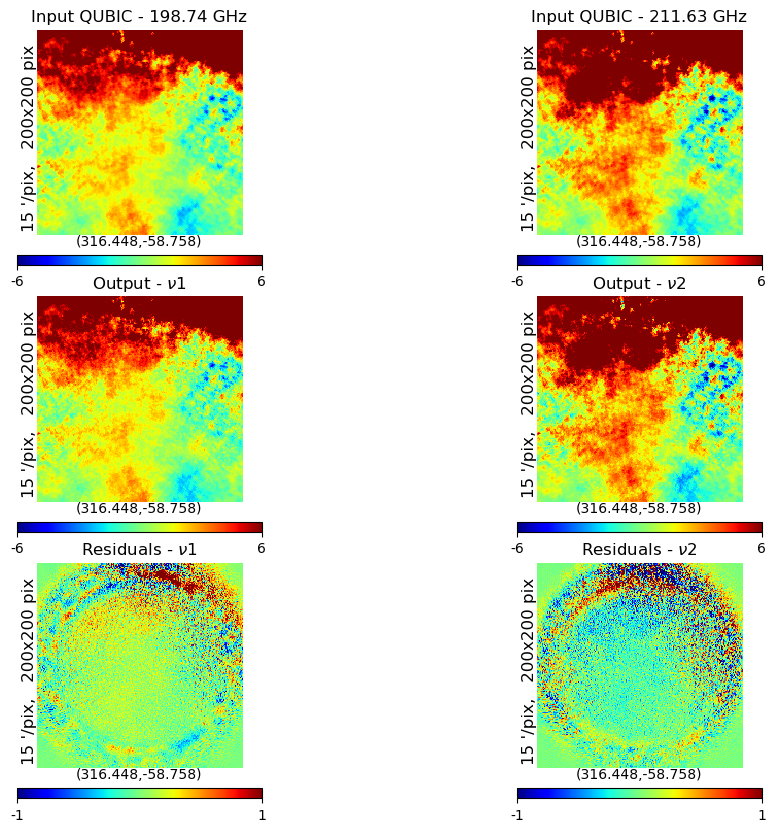

In [23]:
plt.figure(figsize=(10, 8))
res=15
istk=1

for i in range(Nrec):
    C = HealpixConvolutionGaussianOperator(fwhm=qubic_acquisition.final_fwhm[i])
    #inputs = np.mean(m_tod[i*fact:(i+1)*fact], axis=0)
    #inputs = m_planck[0]
    inputs = new_res[i]
    hp.gnomview(C(inputs[:, istk]), rot=center, reso=res, cmap='jet', min=-6, max=6, sub=(3, Nrec, i+1), 
                                        title=f'Input QUBIC - {qubic_acquisition.allnus[i]:.2f} GHz')


for i in range(Nrec):
    hp.gnomview(solution_qubic_planck['x'][i, :, istk], rot=center, reso=res, cmap='jet', min=-6, max=6, sub=(3, Nrec, Nrec+i+1), title=r'Output - $\nu$'+f'{i+1}')


    
for i in range(Nrec):
    C = HealpixConvolutionGaussianOperator(fwhm=qubic_acquisition.final_fwhm[i])
    #inputs = np.mean(m_tod[i*fact:(i+1)*fact], axis=0)
    #inputs = m_planck[0]
    inputs = new_res[i]
    r = C(inputs[:, istk]) - solution_qubic_planck['x'][i, :, istk]
    hp.gnomview(r, rot=center, reso=res, cmap='jet', min=-1, max=1, sub=(3, Nrec, (2*Nrec)+i+1), 
                                        title=r'Residuals - $\nu$'+f'{i+1}')
plt.show()

In [24]:
allcov = np.linspace(0.001, 1, 20)
allcov

array([0.001     , 0.05357895, 0.10615789, 0.15873684, 0.21131579,
       0.26389474, 0.31647368, 0.36905263, 0.42163158, 0.47421053,
       0.52678947, 0.57936842, 0.63194737, 0.68452632, 0.73710526,
       0.78968421, 0.84226316, 0.89484211, 0.94742105, 1.        ])

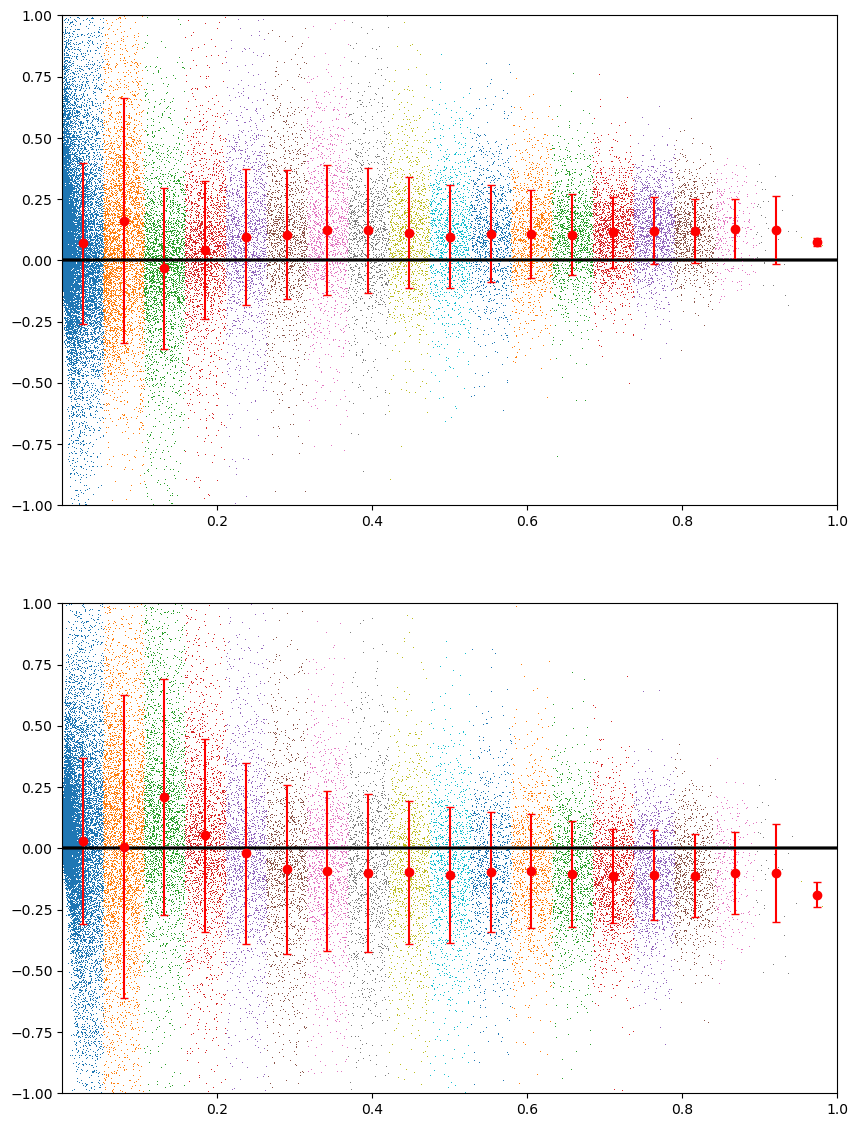

In [25]:
r = np.zeros((Nrec, 12*nside**2))
for i in range(Nrec):
    C = HealpixConvolutionGaussianOperator(fwhm=qubic_acquisition.final_fwhm[i])
    r[i] = C(new_res[i])[:, istk] - solution_qubic_planck['x'][i, :, istk]

plt.figure(figsize=(10, 14))

for i in range(Nrec):
    plt.subplot(Nrec, 1, i+1)
    
    
    for j, jj in enumerate(allcov):
        if jj != 1:
            #print(allcov[j], allcov[j+1])
            index = np.where((covnorm > allcov[j]) & (covnorm < allcov[j+1]))[0]
            #print(index)
            #print(np.mean(r[i][index]), np.std(r[i][index]))
            plt.plot(covnorm[index], r[i][index], ',')
            plt.errorbar(np.mean([allcov[j], allcov[j+1]]), np.mean(r[i][index]), yerr=np.std(r[i][index]), fmt='or', capsize=3)
            plt.axhline(0, color='black')
    #plt.plot(covnorm, r[4], ',')
    #plt.xscale('log')
    plt.xlim(0.001, 1)
    plt.ylim(-1, 1)
plt.show()